In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2
import math


In [20]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [21]:

# Configuration
DATA_CSV_PATH = "role_challenge_dataset_ground_truth.csv"  # Update with your CSV path
IMAGE_DIR = "images"                  # Update with your image directory
IMAGE_SIZE = 256
HEATMAP_SIZE = 64  # Smaller heatmap size for computational efficiency
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
MODEL_SAVE_PATH = "resnet18_heatmap_detector.pth"
SIGMA = 2  # Standard deviation for Gaussian heatmaps


In [22]:
# Fixed dataset class with proper coordinate handling
class HeatmapLandmarkDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        
        # Get landmarks (8 values: ofd_1_x, ofd_1_y, ofd_2_x, ofd_2_y, bpd_1_x, bpd_1_y, bpd_2_x, bpd_2_y)
        landmarks = self.dataframe.iloc[idx, 1:].values.astype('float32')
        
        # Original image dimensions
        orig_width, orig_height = image.size
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        # Create heatmaps for each landmark
        heatmaps = self._create_heatmaps(landmarks, orig_width, orig_height)
            
        return image, heatmaps
    
    def _create_heatmaps(self, landmarks, orig_width, orig_height):
        # Scale factors
        width_scale = HEATMAP_SIZE / orig_width
        height_scale = HEATMAP_SIZE / orig_height
        
        # Initialize heatmaps (8 channels for 8 landmark points)
        heatmaps = np.zeros((8, HEATMAP_SIZE, HEATMAP_SIZE), dtype=np.float32)
        
        for i in range(8):
            if i % 2 == 0:  # x coordinate
                x = landmarks[i] * width_scale
                y = landmarks[i+1] * height_scale
            else:
                continue  # Skip y coordinates as they're handled with x
                
            # Only process even indices (x coordinates) and handle both x and y
            if i % 2 == 0:
                # Create Gaussian heatmap for this landmark point
                heatmap_idx = i // 2  # 0, 1, 2, 3 for the 4 landmarks
                heatmaps[heatmap_idx * 2] = self._generate_2d_gaussian(
                    heatmaps[heatmap_idx * 2], x, y, SIGMA, is_x=True
                )
                heatmaps[heatmap_idx * 2 + 1] = self._generate_2d_gaussian(
                    heatmaps[heatmap_idx * 2 + 1], x, y, SIGMA, is_x=False
                )
            
        return torch.tensor(heatmaps)
    
    def _generate_2d_gaussian(self, heatmap, x_center, y_center, sigma, is_x=True):
        # This function creates a 2D Gaussian distribution centered at the landmark point
        size = heatmap.shape[0]
        x = np.arange(0, size, 1, float)
        y = x[:, np.newaxis]
        x0 = x_center
        y0 = y_center
        
        # Generate Gaussian
        if is_x:
            # For x-coordinate heatmap, emphasize x direction
            g = np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
        else:
            # For y-coordinate heatmap, emphasize y direction
            g = np.exp(-((y - y0) ** 2) / (2 * sigma ** 2))
        
        # Normalize to 0-1
        if g.max() > 0:
            g = g / g.max()
            
        return g

In [23]:

# Define the heatmap model
class HeatmapLandmarkResNet(nn.Module):
    def __init__(self, num_landmarks=8):
        super(HeatmapLandmarkResNet, self).__init__()
        # Use pretrained ResNet18
        self.base_model = models.resnet18(pretrained=True)
        
        # Modify the base model for heatmap prediction
        num_features = self.base_model.fc.in_features
        
        # Replace the final layers with convolutional layers for heatmap prediction
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])
        
        # Add upsampling and convolutional layers to generate heatmaps
        self.upsample = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(size=HEATMAP_SIZE, mode='bilinear', align_corners=True),
            
            nn.Conv2d(64, num_landmarks, kernel_size=1),
            nn.Sigmoid()  # Output values between 0 and 1
        )
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.upsample(x)
        return x

# Data transforms with more augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ]),
}


In [24]:

# Load and prepare data
def prepare_datasets():
    # Load CSV
    df = pd.read_csv(DATA_CSV_PATH)
    
    # Split data
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Create datasets
    train_dataset = HeatmapLandmarkDataset(train_df, IMAGE_DIR, data_transforms['train'])
    val_dataset = HeatmapLandmarkDataset(val_df, IMAGE_DIR, data_transforms['val'])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    return train_loader, val_loader


In [25]:

# Training function for heatmap model
def train_heatmap_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, heatmaps in train_loader:
            images = images.to(device)
            heatmaps = heatmaps.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for images, heatmaps in val_loader:
                images = images.to(device)
                heatmaps = heatmaps.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, heatmaps)
                
                running_val_loss += loss.item() * images.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')
    
    return train_losses, val_losses

# Fixed function to convert heatmaps to coordinates
def heatmaps_to_coordinates(heatmaps, original_size):
    if len(heatmaps.shape) == 4:  # Batch dimension
        batch_size, num_landmarks, h, w = heatmaps.shape
        coordinates = torch.zeros(batch_size, num_landmarks)
        
        for i in range(batch_size):
            for j in range(num_landmarks):
                # Find the position of the maximum value in the heatmap
                heatmap = heatmaps[i, j].cpu().numpy()
                y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
                
                # Convert back to original image coordinates
                if j % 2 == 0:  # x coordinate
                    coordinates[i, j] = x * original_size[0] / w
                else:  # y coordinate
                    coordinates[i, j] = y * original_size[1] / h
                    
        return coordinates
    else:  # Single sample
        num_landmarks, h, w = heatmaps.shape
        coordinates = torch.zeros(num_landmarks)
        
        for j in range(num_landmarks):
            # Find the position of the maximum value in the heatmap
            heatmap = heatmaps[j].cpu().numpy()
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            
            # Convert back to original image coordinates
            if j % 2 == 0:  # x coordinate
                coordinates[j] = x * original_size[0] / w
            else:  # y coordinate
                coordinates[j] = y * original_size[1] / h
                
        return coordinates.unsqueeze(0)  # Add batch dimension


In [26]:
# Fixed visualization function for heatmap predictions
def visualize_heatmap_predictions(model, dataloader, num_samples=3):
    model.eval()
    fig = plt.figure(figsize=(15, 5 * num_samples))
    
    with torch.no_grad():
        sample_count = 0
        for i, (images, heatmaps) in enumerate(dataloader):
            if sample_count >= num_samples:
                break
                
            images = images.to(device)
            heatmaps = heatmaps.to(device)
            
            outputs = model(images)
            
            for j in range(images.size()[0]):
                if sample_count >= num_samples:
                    break
                    
                # Create subplots for this sample
                # Image with landmarks
                ax1 = plt.subplot(num_samples, 3, sample_count * 3 + 1)
                ax1.axis('off')
                ax1.set_title(f'Sample {sample_count+1}: Image with Landmarks')
                
                # Predicted heatmaps
                ax2 = plt.subplot(num_samples, 3, sample_count * 3 + 2)
                ax2.axis('off')
                ax2.set_title(f'Sample {sample_count+1}: Predicted Heatmaps')
                
                # Ground truth heatmaps
                ax3 = plt.subplot(num_samples, 3, sample_count * 3 + 3)
                ax3.axis('off')
                ax3.set_title(f'Sample {sample_count+1}: Ground Truth Heatmaps')
                
                # Denormalize image
                img = images.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                # Get predicted and ground truth heatmaps
                pred_heatmaps = outputs.cpu().data[j].numpy()
                true_heatmaps = heatmaps.cpu().data[j].numpy()
                
                # Convert heatmaps to coordinates
                pred_coords = heatmaps_to_coordinates(outputs[j:j+1], (IMAGE_SIZE, IMAGE_SIZE))[0]
                true_coords = heatmaps_to_coordinates(heatmaps[j:j+1], (IMAGE_SIZE, IMAGE_SIZE))[0]
                
                # Plot original image with landmarks
                ax1.imshow(img)
                
                # Plot predicted landmarks (red)
                ax1.scatter(pred_coords[0], pred_coords[1], c='r', marker='x', s=100, label='Pred OFD1' if sample_count == 0 else "")
                ax1.scatter(pred_coords[2], pred_coords[3], c='r', marker='x', s=100, label='Pred OFD2' if sample_count == 0 else "")
                ax1.scatter(pred_coords[4], pred_coords[5], c='r', marker='x', s=100, label='Pred BPD1' if sample_count == 0 else "")
                ax1.scatter(pred_coords[6], pred_coords[7], c='r', marker='x', s=100, label='Pred BPD2' if sample_count == 0 else "")
                
                # Plot true landmarks (green)
                ax1.scatter(true_coords[0], true_coords[1], c='g', marker='o', s=100, facecolors='none', label='True OFD1' if sample_count == 0 else "")
                ax1.scatter(true_coords[2], true_coords[3], c='g', marker='o', s=100, facecolors='none', label='True OFD2' if sample_count == 0 else "")
                ax1.scatter(true_coords[4], true_coords[5], c='g', marker='o', s=100, facecolors='none', label='True BPD1' if sample_count == 0 else "")
                ax1.scatter(true_coords[6], true_coords[7], c='g', marker='o', s=100, facecolors='none', label='True BPD2' if sample_count == 0 else "")
                
                if sample_count == 0:
                    ax1.legend()
                
                # Plot predicted heatmaps
                all_pred_heatmaps = np.max(pred_heatmaps, axis=0)
                ax2.imshow(all_pred_heatmaps, cmap='hot')
                
                # Plot ground truth heatmaps
                all_true_heatmaps = np.max(true_heatmaps, axis=0)
                ax3.imshow(all_true_heatmaps, cmap='hot')
                
                sample_count += 1
        
    plt.tight_layout()
    return fig


In [27]:
# Check if the model already exists
if os.path.exists(MODEL_SAVE_PATH):
    # Load the pre-trained model
    print("Loading pre-trained model...")
    model = HeatmapLandmarkResNet().to(device)
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print("Pre-trained model loaded.")
    
    # Prepare data
    print("Preparing datasets...")
    train_loader, val_loader = prepare_datasets()
    
    # Define loss function (MSE for heatmaps)
    criterion = nn.MSELoss()
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Train model
    print("Starting training...")
    train_losses, val_losses = train_heatmap_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

    # Save model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")
else:
    # Prepare data
    print("Preparing datasets...")
    train_loader, val_loader = prepare_datasets()

    # Initialize model
    model = HeatmapLandmarkResNet().to(device)

    # Define loss function (MSE for heatmaps)
    criterion = nn.MSELoss()

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Train model
    print("Starting training...")
    train_losses, val_losses = train_heatmap_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

    # Save model
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved to {MODEL_SAVE_PATH}")


Loading pre-trained model...


Pre-trained model loaded.
Preparing datasets...
Starting training...


/home/sachudeva/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.042656, Val Loss: 0.039847
Epoch 2/50, Train Loss: 0.038049, Val Loss: 0.037485
Epoch 3/50, Train Loss: 0.035988, Val Loss: 0.036039
Epoch 4/50, Train Loss: 0.035043, Val Loss: 0.034980
Epoch 5/50, Train Loss: 0.034163, Val Loss: 0.034245
Epoch 6/50, Train Loss: 0.033621, Val Loss: 0.034719
Epoch 7/50, Train Loss: 0.032921, Val Loss: 0.034702
Epoch 8/50, Train Loss: 0.032819, Val Loss: 0.034464
Epoch 9/50, Train Loss: 0.032458, Val Loss: 0.034311
Epoch 10/50, Train Loss: 0.031941, Val Loss: 0.033442
Epoch 11/50, Train Loss: 0.031257, Val Loss: 0.033910
Epoch 12/50, Train Loss: 0.030560, Val Loss: 0.032476
Epoch 13/50, Train Loss: 0.030905, Val Loss: 0.032407
Epoch 14/50, Train Loss: 0.030525, Val Loss: 0.032786
Epoch 15/50, Train Loss: 0.029994, Val Loss: 0.032744
Epoch 16/50, Train Loss: 0.029162, Val Loss: 0.034065
Epoch 17/50, Train Loss: 0.029581, Val Loss: 0.032890
Epoch 18/50, Train Loss: 0.028751, Val Loss: 0.032386
Epoch 19/50, Train Loss: 0.028748, Va

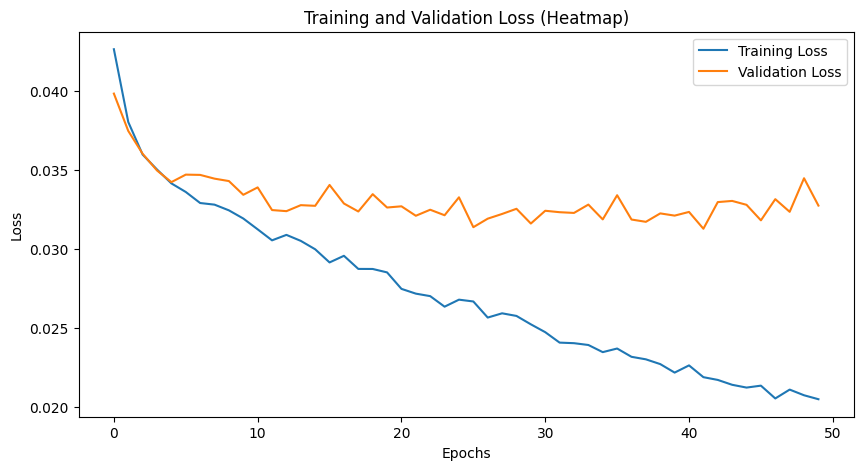

Visualizing predictions...


/tmp/ipykernel_319932/1524100085.py:62: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax1.scatter(true_coords[0], true_coords[1], c='g', marker='o', s=100, facecolors='none', label='True OFD1' if sample_count == 0 else "")
/tmp/ipykernel_319932/1524100085.py:63: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax1.scatter(true_coords[2], true_coords[3], c='g', marker='o', s=100, facecolors='none', label='True OFD2' if sample_count == 0 else "")
/tmp/ipykernel_319932/1524100085.py:64: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  ax1.scatter(true_coords[4], true_coords[5], c='g', marker='o', s=100, facecolors='none', label='True BPD1' if sample_count == 0 e

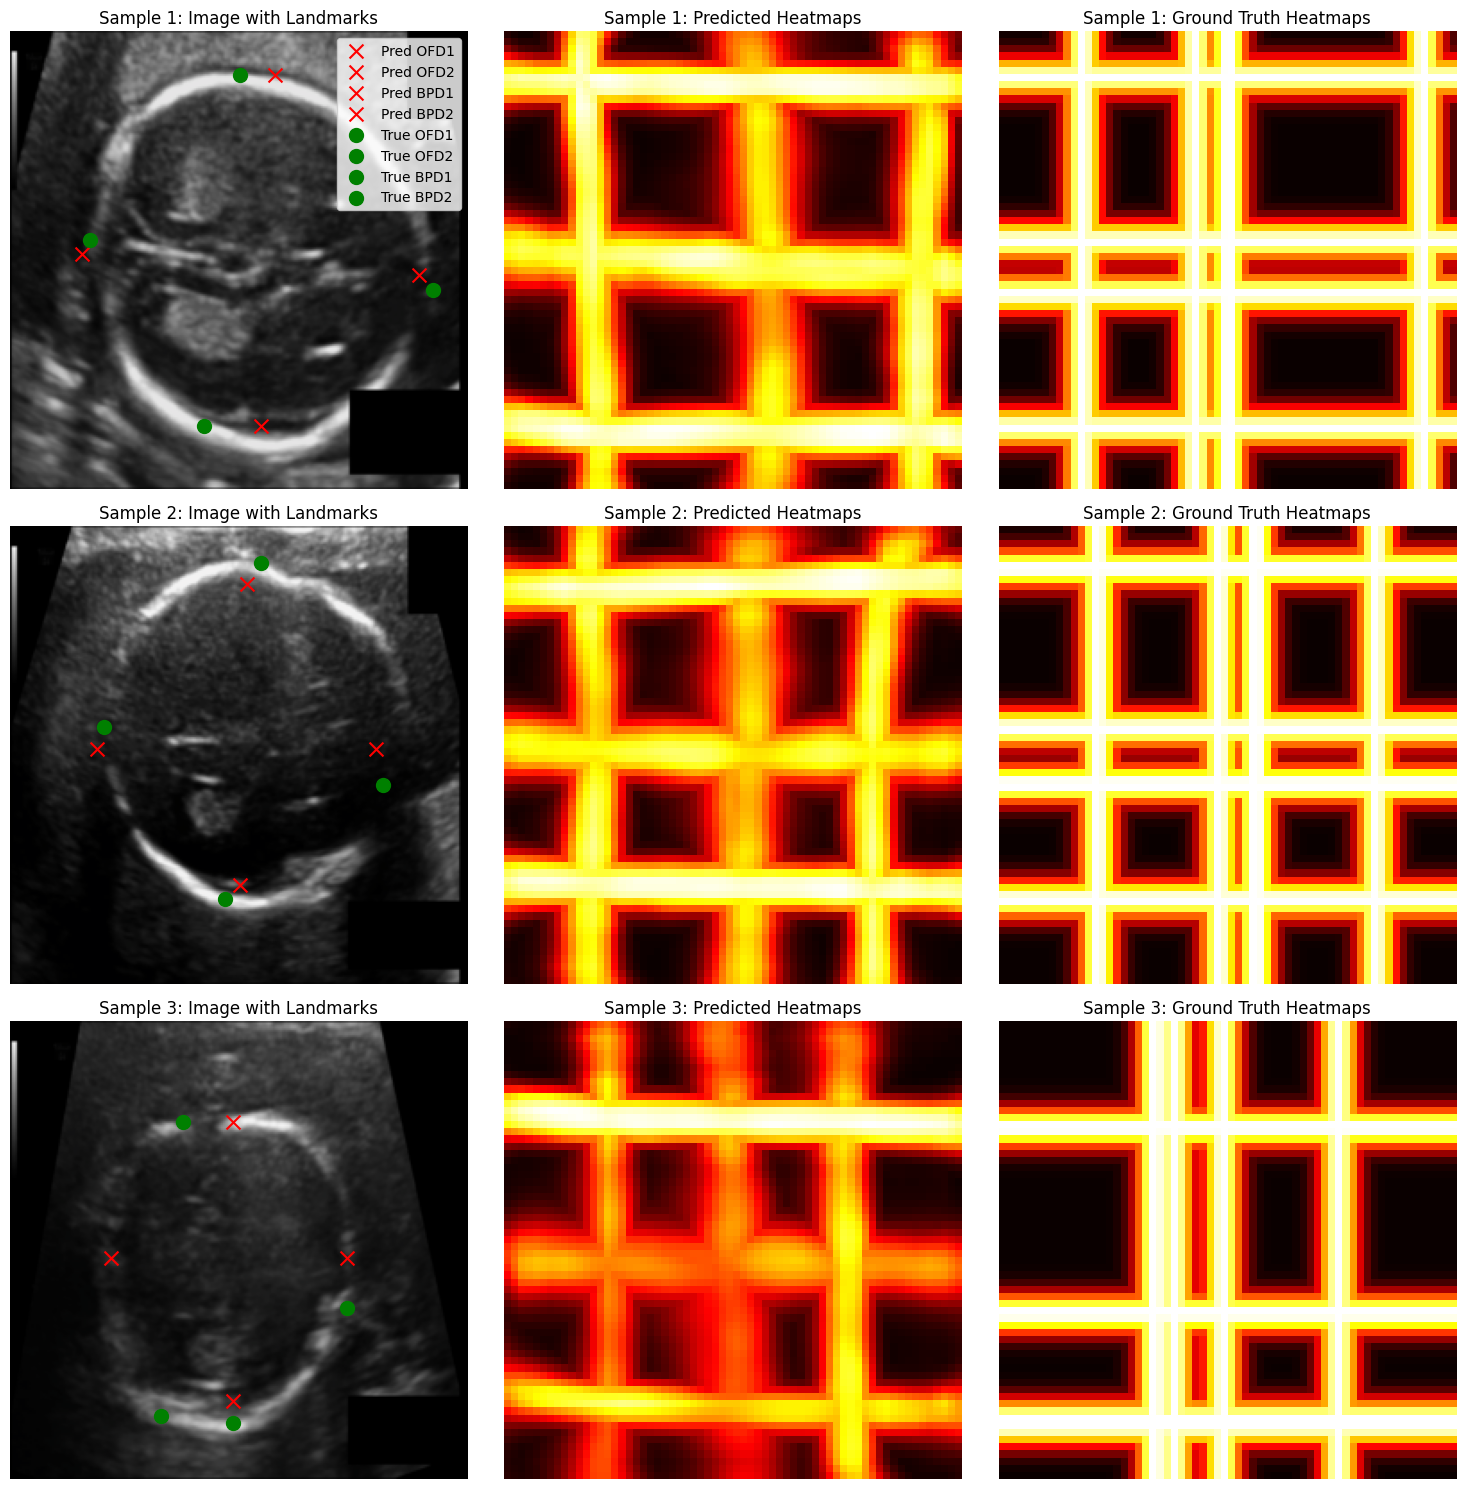

Calculating evaluation metrics...
Mean Absolute Error: 20.31 pixels
Success rate with 2px threshold: 12.60%
Success rate with 5px threshold: 32.70%
Success rate with 10px threshold: 52.40%


In [28]:

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Heatmap)')
plt.legend()
plt.savefig('heatmap_training_history.png')
plt.show()

# Visualize predictions
print("Visualizing predictions...")
fig = visualize_heatmap_predictions(model, val_loader, num_samples=3)
plt.savefig('heatmap_predictions_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate evaluation metrics
print("Calculating evaluation metrics...")
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, heatmaps in val_loader:
        images = images.to(device)
        outputs = model(images)
        
        # Convert heatmaps to coordinates
        pred_coords = heatmaps_to_coordinates(outputs, (IMAGE_SIZE, IMAGE_SIZE))
        target_coords = heatmaps_to_coordinates(heatmaps, (IMAGE_SIZE, IMAGE_SIZE))
        
        all_preds.append(pred_coords)
        all_targets.append(target_coords)

# Calculate Mean Absolute Error
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

mae = torch.mean(torch.abs(all_preds - all_targets))
print(f"Mean Absolute Error: {mae:.2f} pixels")

# Calculate success rate with different thresholds
thresholds = [2, 5, 10]  # pixels
for threshold in thresholds:
    success_rate = torch.mean((torch.abs(all_preds - all_targets) < threshold).float()) * 100
    print(f"Success rate with {threshold}px threshold: {success_rate:.2f}%")